# $\underline{\textbf{Housing Price prediction a Kaggle challenge}}$

## $\textbf{Bastien Zimmermann}$                        
$\textit{last modification : 29/08/2019}$

---
# Introduction
$\\\text{This notebook is an attempt to solve the famous Kaggle Challenge : House Prices: Advanced Regression Techniques}$
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation

$\text{This is the first data science challenge i had ever attempted. This notebook is an updated version of the work i did while}\\\text{ in a EURECOM course : AML (Advanced Machine Learning)}$

$\text{The task allows to set up for fundamentals and develop a solid method for data-science problem solving.}$

---

First off let's just import libraries that we will need and load the data.

### $\textbf{Import libraries :}$

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import scipy.stats as stats

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, LassoLarsIC, Lasso, BayesianRidge, Ridge, LassoLars, LassoLarsCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, ParameterSampler


### $\textbf{Load Data}$

In [2]:
#Load the data
trainDF = pd.read_csv('./train.csv')
testDF = pd.read_csv('./test.csv')

---
# 1. Data Exploration
---
Before attempting anything, let's first stop and have a look at what we have. The challenge is about infering the house prices hence the variable 'SalePrice' is definetly key and our exploration should focus around this data.

Let's have a look at the distribution of those sale prices.

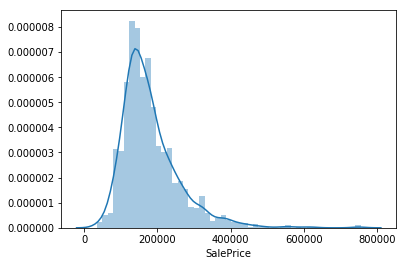

In [3]:
sns.distplot(trainDF['SalePrice'])

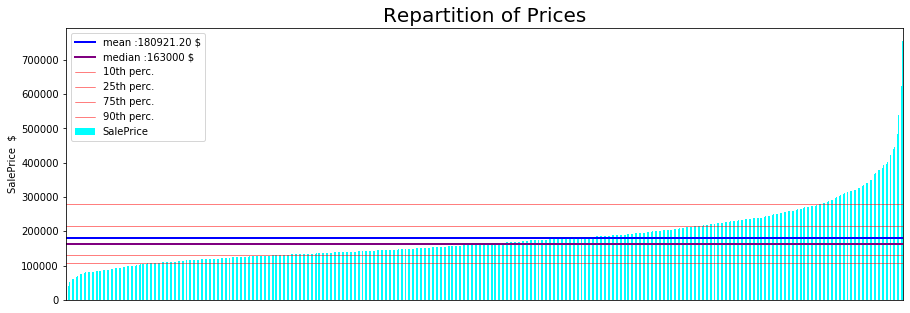

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [4]:
fig, ax = plt.subplots(figsize=[15,5])

trainDF['SalePrice'].sort_values().plot(kind='bar', ax = ax, xticks=None, cmap='cool')
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)

plt.axhline(trainDF['SalePrice'].mean(),c = 'b', linewidth = 2, label = "mean :" + "%.2f"%trainDF['SalePrice'].mean()+ " $")
plt.axhline(trainDF['SalePrice'].median(),c = 'purple', linewidth = 2, label = "median :" + "%.0f"%trainDF['SalePrice'].median()+ " $")

for i, quantile in enumerate([.1, 0.25, .75, .9]):
    ax.axhline(trainDF['SalePrice'].quantile(quantile), label='%.0fth perc.' % (quantile*100), color = 'r', linewidth = 0.5)
    
plt.ylabel("SalePrice  $")
plt.legend()
plt.title('Repartition of Prices',fontsize = 20)
plt.show()
trainDF['SalePrice'].describe()

In [5]:
print('The skewness in Sale price is : %.5f'%trainDF['SalePrice'].skew())
print('The Kurtosis in Sale price is : %.5f'%trainDF['SalePrice'].kurt())

The skewness in Sale price is : 1.88288
The Kurtosis in Sale price is : 6.53628


$\text{This first look on SalePrice indicates that it does not follow the natural normal distribution, that would have to be changed through a}\\\text{transformation (most likely log).}$

$\text{Let's now observe its relation with respect to the others categories.}$

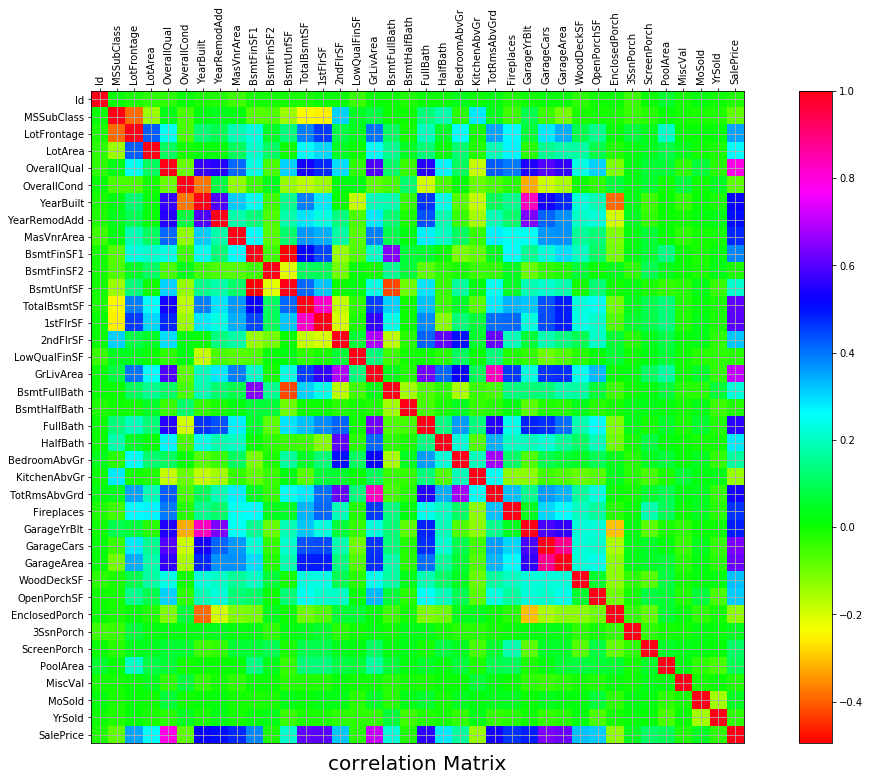

In [6]:
cor = trainDF.corr()
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))


fig, ax = plt.subplots(figsize=[20,12])

plt.title("correlation Matrix", fontsize = 20, y=-0.05)
image = ax.imshow(cor, cmap = 'hsv')

plt.xticks(np.arange(len(cor.columns)),cor.columns, rotation = 'vertical')
ax.xaxis.tick_top()
plt.yticks(np.arange(len(cor.columns)),cor.columns, rotation = 'horizontal')
fig.colorbar(image, ax=ax)
plt.rcParams['grid.color'] = "w"
plt.grid()
plt.show()

#Add analysis of corr matrix

BsmtUnfSF and BsmtFinSF1 are logically heavily correlated. In a similar fashion 1stFlrSF and TotalBsmtSf are heavily correlated are houses a often build this way. GrLiveAre and TotRmsAbvGrd. 
We will examine the correlation with SalePrice a bit closer.

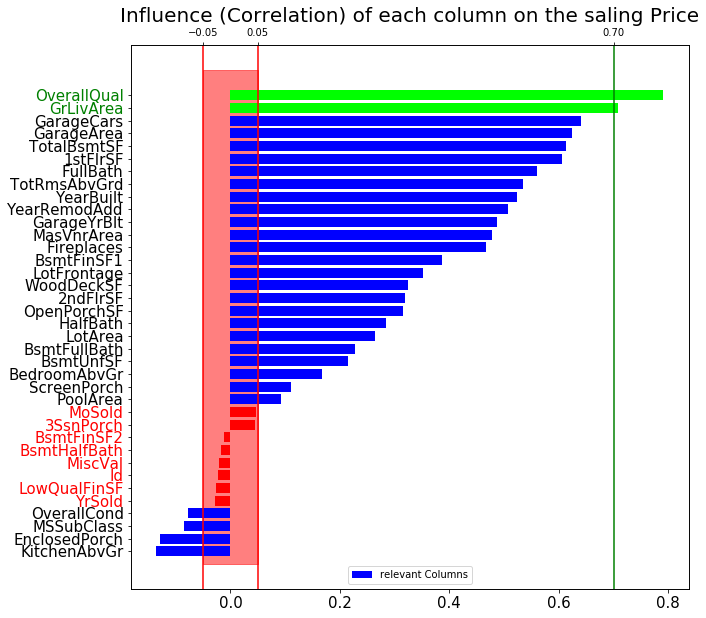

In [7]:
#order the correlations and their associated column
minCorrValue = 0.05
goodCorrValue = 0.7

corrOrdered = list(upper['SalePrice'].copy().sort_values())
numNan = upper['SalePrice'].isnull().sum()
colOrdered = [upper.columns[list(upper['SalePrice']).index(x)] for x in corrOrdered[:-numNan]]

# We have colOrdered, corrOrdered, numNan, lowCorrelatedColumns

lowCorrelatedColumns, highCorrelatedColumns = [], []

#get the high and low correlated columns + color
colorList= ['b']*len(colOrdered)
for x in corrOrdered:
    if abs(x) in [x for x in list(upper['SalePrice'].abs()) if x<minCorrValue]:
        colorList[corrOrdered.index(x)] = 'r'                    #undecoralated columns are red
        lowCorrelatedColumns.append(colOrdered[corrOrdered.index(x)])
    if abs(x) in [x for x in list(upper['SalePrice'].abs()) if x>goodCorrValue]:
        colorList[corrOrdered.index(x)] = 'lime'                    #undecoralated columns are red
        highCorrelatedColumns.append(colOrdered[corrOrdered.index(x)])
                        
            
plt.figure(figsize=[10,10])
plt.barh(colOrdered,corrOrdered[:-numNan], color=colorList)
plt.title("Influence (Correlation) of each column on the saling Price", fontsize=20)
plt.tick_params(labelsize=15)
plt.legend( ['relevant Columns','good'])
plt.axvline(x= minCorrValue, c='r')
plt.fill_between([-minCorrValue,minCorrValue], [len(upper),len(upper)],[-1,-1], alpha = 0.5, color = 'red')
plt.axvline(x= -minCorrValue, c='r')
plt.axvline(x= goodCorrValue, c='g')
ax = plt.gca()
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-minCorrValue,minCorrValue,goodCorrValue])

#color the yticks
for x in lowCorrelatedColumns:
        ax.get_yticklabels()[colOrdered.index(x)].set_color("red")
for x in highCorrelatedColumns:
        ax.get_yticklabels()[colOrdered.index(x)].set_color("green")

plt.show()
#print("Low correlatedColumns", lowCorrelatedColumns)


$\text{Quite nicely overallQual is heavily correlated with the sale price hence most sales are not scams nor presents.}\\\text{The red columns are under-correlated they can be dropped.}\\\text{Droping them would deacrease the weight of the data and ease the computation. This is not required here, the more data the merrier!}$

$\text{Let's now have a look of an analisys of the qualitative columns variance : ANOVA}$

/home/bastienzimmermann/.local/lib/python3.6/site-packages/scipy/stats/stats.py:2951: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / len(a)


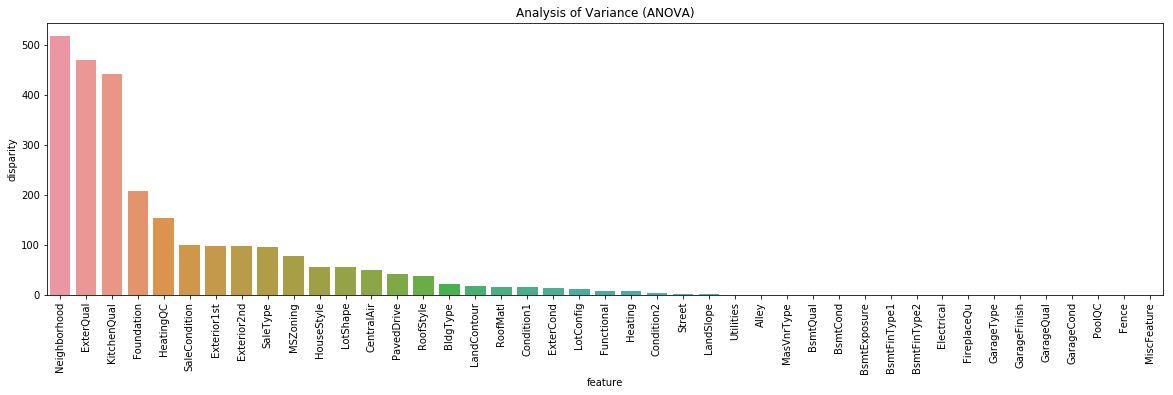

In [8]:
qualitative = trainDF.select_dtypes('object').columns

plt.figure(figsize = [20,5])
anova = pd.DataFrame(columns = ['feature','pvalue'])
anova['feature'] = qualitative
for col in qualitative: #for each qualitative column we get the pvalues
    samples = []
    for elt in trainDF[col].unique():
        samples.append(trainDF['SalePrice'][trainDF[col] == elt].values)
    a = stats.f_oneway(*samples)
    anova['pvalue'][anova['feature']==col] = a.pvalue
    
#sort and cast
anova = anova.sort_values('pvalue')
anova['pvalue'] = anova['pvalue'].astype('float') 
#transform for better visualisation and plot
anova['disparity'] = np.log(1./anova['pvalue'].values)
#anova.plot(kind='bar',x = 'feature',y = 'disparity', cmap = 'rainbow')
sns.barplot(data=anova, x='feature', y='disparity')
x=plt.xticks(rotation=90)
plt.title('Analysis of Variance (ANOVA)')
plt.show()

$\text{Let's now have a look of some pair plots :}$

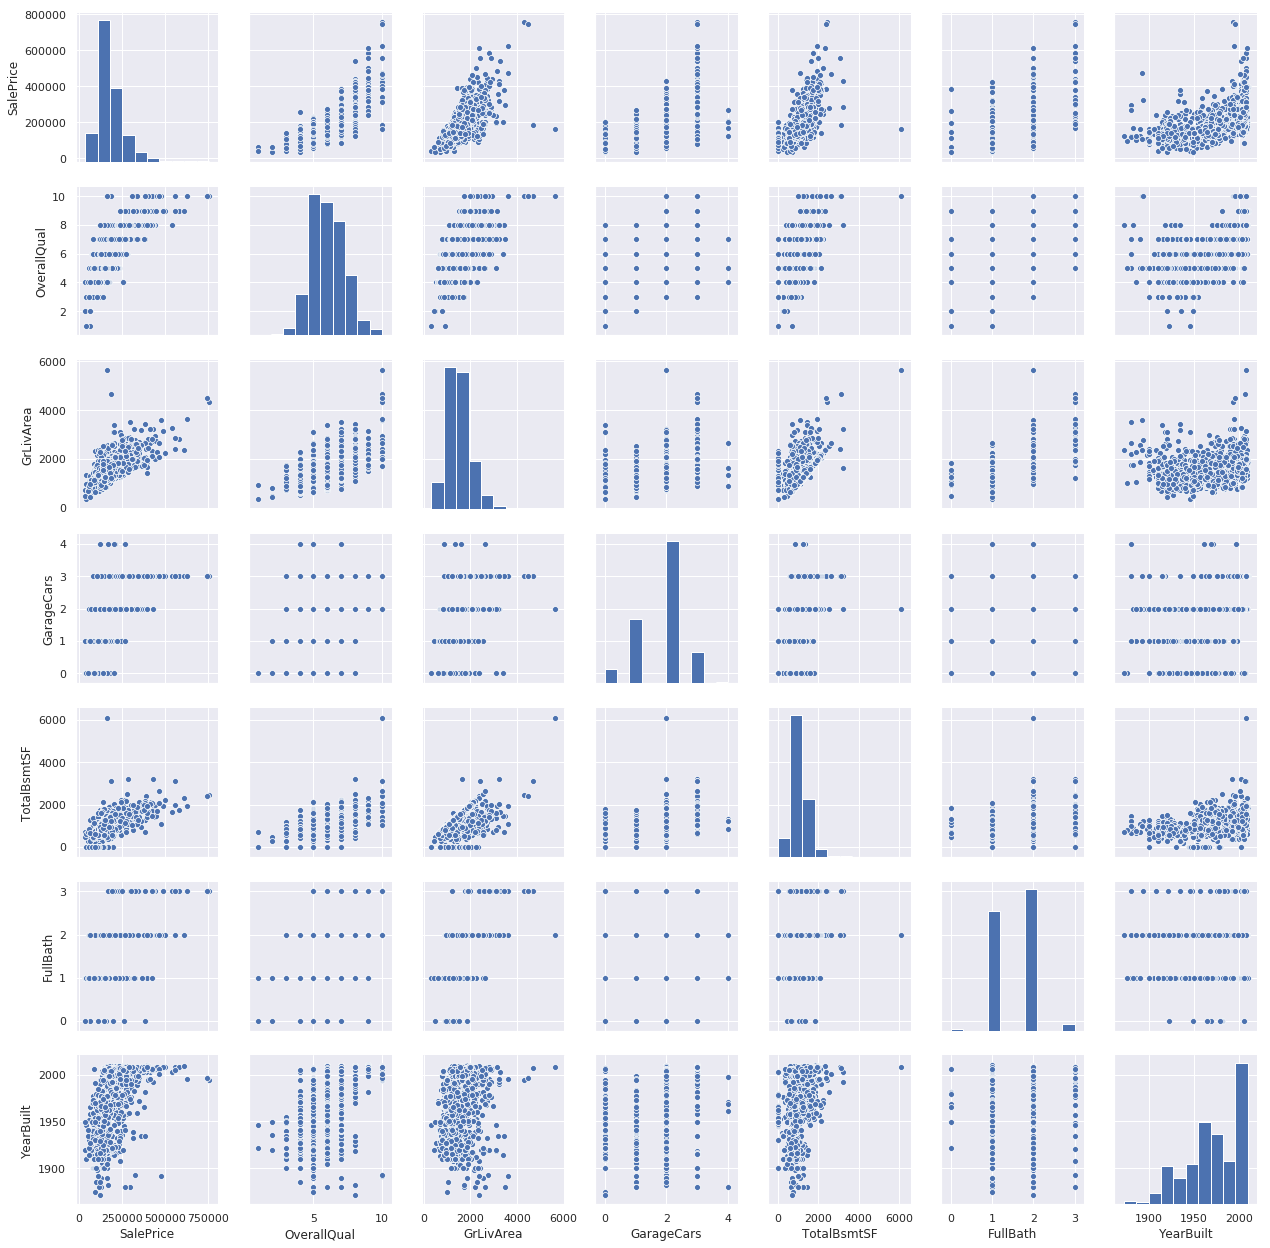

In [9]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(trainDF[cols], height = 2.5)
plt.show()

$\text{The seaborn library makes our job super-easy. This kind of plot while giving an overview of the data allows to spot visualy outliers.}$

---
# $\textbf{2. Outliers}$
---

$\text{Dealing with outliers is essential, this can be a nightmare for data-scientists. Some isolated values incoherent due to some }\\\text{measurement errors or some outerfactor can really hinder the inference precision.}$
$\text{In order to deal with them, data visualisation can come quite handy.}$


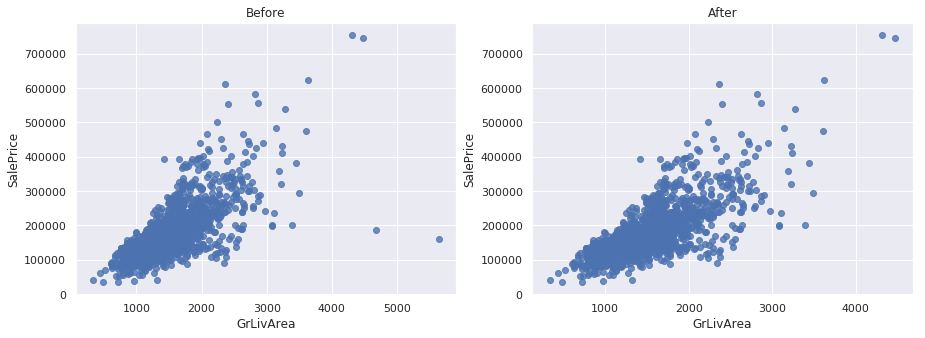

In [10]:
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=trainDF['GrLivArea'], y=trainDF['SalePrice'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
trainDF = trainDF.drop(trainDF[(trainDF['GrLivArea']>4500)].index)
g = sns.regplot(x=trainDF['GrLivArea'], y=trainDF['SalePrice'], fit_reg=False).set_title("After")

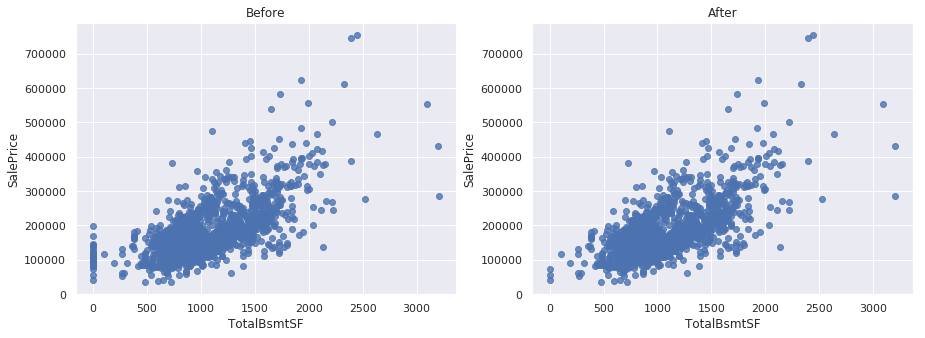

In [11]:
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=trainDF['TotalBsmtSF'], y = trainDF['SalePrice'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                
trainDF = trainDF.drop(trainDF[(trainDF['TotalBsmtSF']<1) & (trainDF['SalePrice']>80000)].index)
g = sns.regplot(x=trainDF['TotalBsmtSF'], y = trainDF['SalePrice'], fit_reg=False).set_title("After")

In [12]:
# First of all, save the length of the training and test data for use later
ntrain = trainDF.shape[0]
ntest = testDF.shape[0]

# Also save the target value, as we will remove this
y_train = trainDF.SalePrice.values

# concatenate training and test data into all_data
all_data = pd.concat((trainDF, testDF), sort=False).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data shape: {}".format(all_data.shape))

all_data shape: (2883, 80)


---
## $\textbf{3. Missing Values}$
---

Dealing with nan values and missing data is essential. The brute force approach of deleting every row with incomplete data would lead us to non sufficient data or non representative data.

This notebook explored in its past several ways of dealing with missing values, the best performing one was kept. It was coincidentially also the most sensible, logical one. This highlights the importance of dealing carefully with this step.

First let's take a look at the missing values:

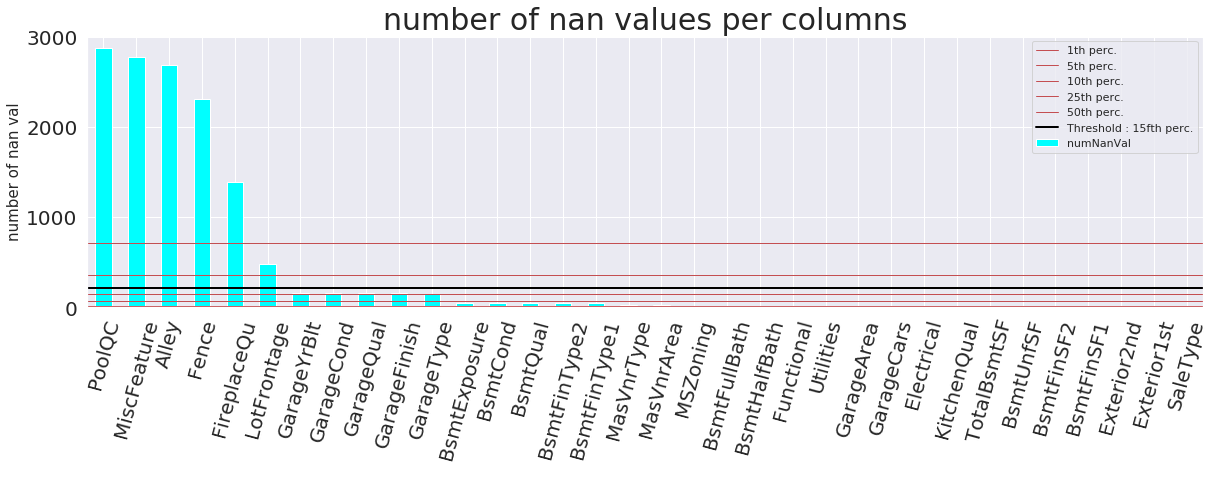

In [13]:
def findNanValDF(df):
    nanValDF = pd.DataFrame(columns = ['colName',"numNanVal"])
    for x in df:
        nanVal = df[x].isnull().sum()
        if nanVal > 0:
            nanValDF = nanValDF.append({'colName': x, "numNanVal" :nanVal}, ignore_index=True)
    nanValDF.index = nanValDF['colName']
    nanValDF = nanValDF.drop(columns = ['colName'])
    return (nanValDF.sort_values(by='numNanVal', ascending = False))

#dealing with missing values:
#where are they ?
fig, ax = plt.subplots(figsize=[20,5])

nanValDF = findNanValDF(all_data)

nanValDF.sort_values(by='numNanVal', ascending = False).plot(kind='bar', ax = ax, cmap='cool')
plt.tick_params(labelsize=20)
plt.ylabel("number of nan val", fontsize=15)
plt.xlabel(" ")
plt.title("number of nan values per columns", fontsize=30)
#total number of values
numVal = len(trainDF.values)

for i, quantile in enumerate([.01, 0.05, .1, .25, .5]):
    ax.axhline(numVal*quantile,c='r', linewidth=1, label='%.0fth perc.' %(quantile*100))
ax.axhline(numVal*0.15,c='black', linewidth=2, label='Threshold : 15fth perc.')

    
plt.legend()
plt.xticks(rotation = 75)
plt.show()

$\text{First we shall get rid of the less meaningfull columns. It is often preferable to ignore the ones with more than 15% missing values.}$

In [14]:
#drop the columns with more than 15% of missing values -> they dont give a lot of information.
print("Columns dropped because of too much missing data :")
#missing data
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

#Drop the less meaningfull columns
for x in missing_data[missing_data['Percent'] > 0.15].index: 
    all_data = all_data.drop(columns = x)
#print    
missing_data[missing_data['Percent'] > 0.15].head(20)


Columns dropped because of too much missing data :


,Total,Percent
PoolQC,2874,0.996878
MiscFeature,2780,0.964273
Alley,2686,0.931668
Fence,2316,0.803330
FireplaceQu,1395,0.483871
LotFrontage,481,0.166840


$\text{A closer look at the dataset description led the following transcription:}$

$\text{The values of certain columns are seemingly grades, the grades are being traduced to numerical values.}$
$\text{The following conversion was used:}$

$\text{Main case:  : {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 'No' : 0}}
\\\text{Bsmt Exposure : {'Gd' : 4, 'Av' : 3, 'Mn' : 2, 'No' : 1, 'Na' : 0}}
\\\text{BsmtFinType  : {'GLQ' : 6, 'ALQ' : 5, 'BLQ' : 4, 'Rec' : 3, 'LwQ' : 2, 'Unf' : 1, 'NA' : 0}}
\\\text{GarageFinish : {'RFn' : 3 , 'Unf' : 1, 'Fin' : 2}}$

$\text{Columns concerned: ExterQual, ExterCond, BsmtQual, BsmtCond, HeatingQC, KitchenQual, FireplaceQu, GarageQual,}\\\text{GarageCond, BsmtExposure, BsmtFinType1, BsmtFinType2}$


In [15]:
#Note: Fence, FireplaceQu and Fence have been commented due to too many missing values
specialColumnList=['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                'HeatingQC', 'KitchenQual',# 'FireplaceQu',
                'GarageQual', 'GarageCond']#, 'PoolQC']
specialColumnList2 = ['BsmtExposure','BsmtFinType1','BsmtFinType2']
dictBsmtExposure = {'Gd':4,'Av':3,'Mn':2,'No':1,'Na':0} #Order subject to interpretation
dictBsmtFinType  = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0}
valTranslationDict = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No':0}
dictGarageFinish = {'RFn':3 ,'Unf':1, 'Fin':2}


#-----------------------------------------------------------------------------------------------    
#Deal with the special columns
for col in specialColumnList:#assign to dict value, replace nan with 0 and cast it
    all_data[col] = all_data[col].map(valTranslationDict).fillna(0).astype(np.int64)

all_data['BsmtExposure'] = all_data['BsmtExposure'].map(dictBsmtExposure).fillna(0).astype(np.int64)
all_data['GarageFinish'] = all_data['GarageFinish'].map(dictGarageFinish).fillna(0).astype(np.int64)
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].map(dictBsmtFinType).fillna(0).astype(np.int64)
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].map(dictBsmtFinType).fillna(0).astype(np.int64)


In [16]:
print('number of nan values :',np.sum(all_data.isnull().sum())) #check the remaining number of nan values

number of nan values : 375


$\text{We now fill the rest of the missing values automatically, as there are not that many it won't have a nefast impact.}$

In [17]:
#The following cell works for the columns with numerical values.
#Note that this automated approch works if there aren't many missing values to fill.
#An in depth analysis of each columns is still preferable.

fillMedian = []
fill0 = []
fillMode = []

nanValDF = findNanValDF(all_data).sort_values(by='numNanVal', ascending = False)
for x in nanValDF.index:
    if(all_data[x].dtypes != object):
        print(x,":", nanValDF[nanValDF.index == x].values[0][0],'nan values')
        print(all_data[x].nunique(),"unique values",', median :', all_data[x].median(), ',mean', all_data[x].mean(),'\n')
        #print(np.sort(trainDF[x].unique()),'\n')
        
        if(abs(all_data[x].median() - all_data[x].mean())/all_data[x].mean() < 0.05):
            print('     ||||||---------> can fill na with median because close to mean !', '\n')
            fillMedian.append(x)
        elif(all_data[x].median() == 0):
            print('     ||||||---------> can fill na with 0 because median = 0 !', '\n')
            fill0.append(x)
        else:
            print('     ||||||---------> fill with mode by default', '\n')
            fillMode.append(x)
            
print('\nThe following columns are object type :\n')
for x in nanValDF.index:
    if(all_data[x].dtypes == object):      
        print('  ',x,":", nanValDF[nanValDF.index == x].values[0][0],'nan values')
        fillMode.append(x)
        #print('    ',trainDF[x].nunique(), 'unique values\n')
        

GarageYrBlt : 154 nan values
103 unique values , median : 1979.0 ,mean 1978.2176621473068 

     ||||||---------> can fill na with median because close to mean ! 

MasVnrArea : 23 nan values
442 unique values , median : 0.0 ,mean 102.47692307692307 

     ||||||---------> can fill na with 0 because median = 0 ! 

BsmtFullBath : 2 nan values
4 unique values , median : 0.0 ,mean 0.4342242276987157 

     ||||||---------> can fill na with 0 because median = 0 ! 

BsmtHalfBath : 2 nan values
3 unique values , median : 0.0 ,mean 0.06213120444290177 

     ||||||---------> can fill na with 0 because median = 0 ! 

BsmtFinSF2 : 1 nan values
272 unique values , median : 0.0 ,mean 50.201596113809856 

     ||||||---------> can fill na with 0 because median = 0 ! 

BsmtFinSF1 : 1 nan values
989 unique values , median : 375.0 ,mean 444.19465648854964 

     ||||||---------> fill with mode by default 

GarageArea : 1 nan values
601 unique values , median : 480.0 ,mean 473.45350451075643 

     |||

$\text{We then proceed to the corresponding changes. We can also add some different opperation depending our reasoning.}$

In [18]:
#proceed to the corresponding changes
for x in fill0:
    all_data[x] = all_data[x].fillna(0)
for x in fillMedian:
    all_data[x] = all_data[x].fillna(all_data[x].median())
for x in fillMode:
    all_data[x] = all_data[x].fillna(all_data[x].mode().values[0])
    
#Drop the following columns
#all_data = all_data.drop(columns = ['GarageType','MasVnrType','Electrical'])


print('number of nan values :',all_data.isnull().sum().max()) #check we did not forget anything

number of nan values : 0


---
# $\textbf{4. Normalisation of the data}$
---
$\text{Some variable distributions do not follow the normal, hence it is better to transform those.}$


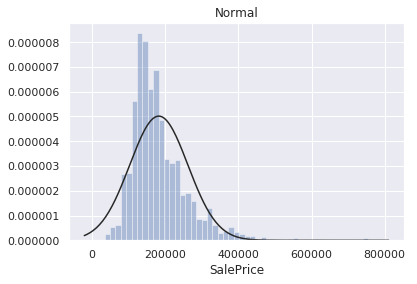

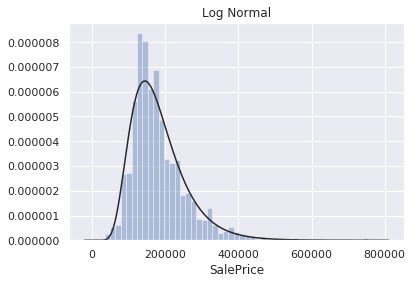

In [19]:
y = trainDF['SalePrice']
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)
plt.show()

$\text{Here we check that the log transformation is quite adapted to rectify the Saleprice's distribution.}$

In [20]:
#separate features in quantitative and qualitative for a separate analysis
quantitative = list(all_data.select_dtypes('number').columns)
quantitative.remove('Id')
qualitative = all_data.select_dtypes('object').columns

$\text{We test if the quantitatives variable are normal, wether or not they need some adjustment.}$

In [21]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(all_data[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


The test resulted in False hence an action is required!

Using once again the wonderfull library seaborn, let's have a look at those distributions.

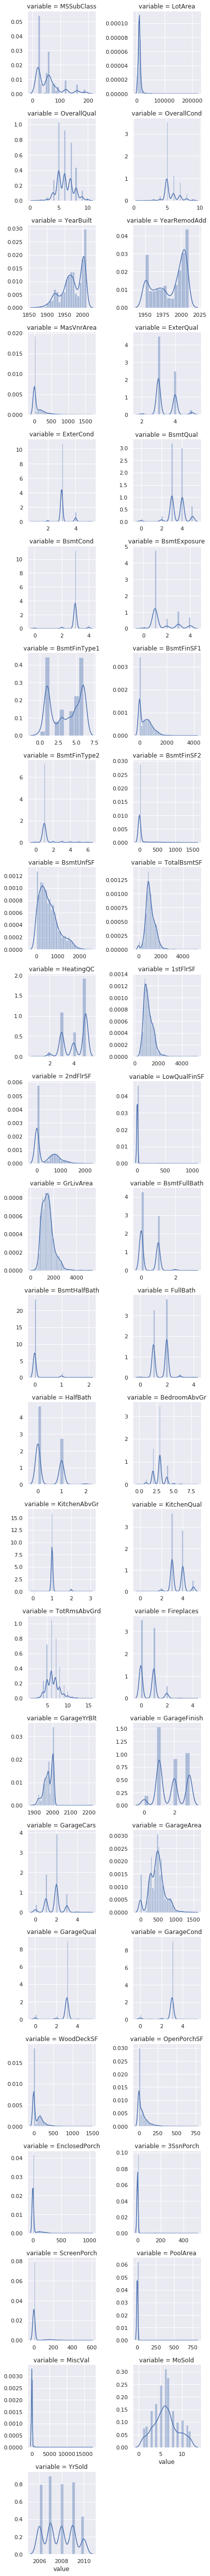

In [22]:
f = pd.melt(all_data, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

Now the qualitative features. 
Some boxplot could come quite handy to inspect the disparity, the influence of each value on SalePrice

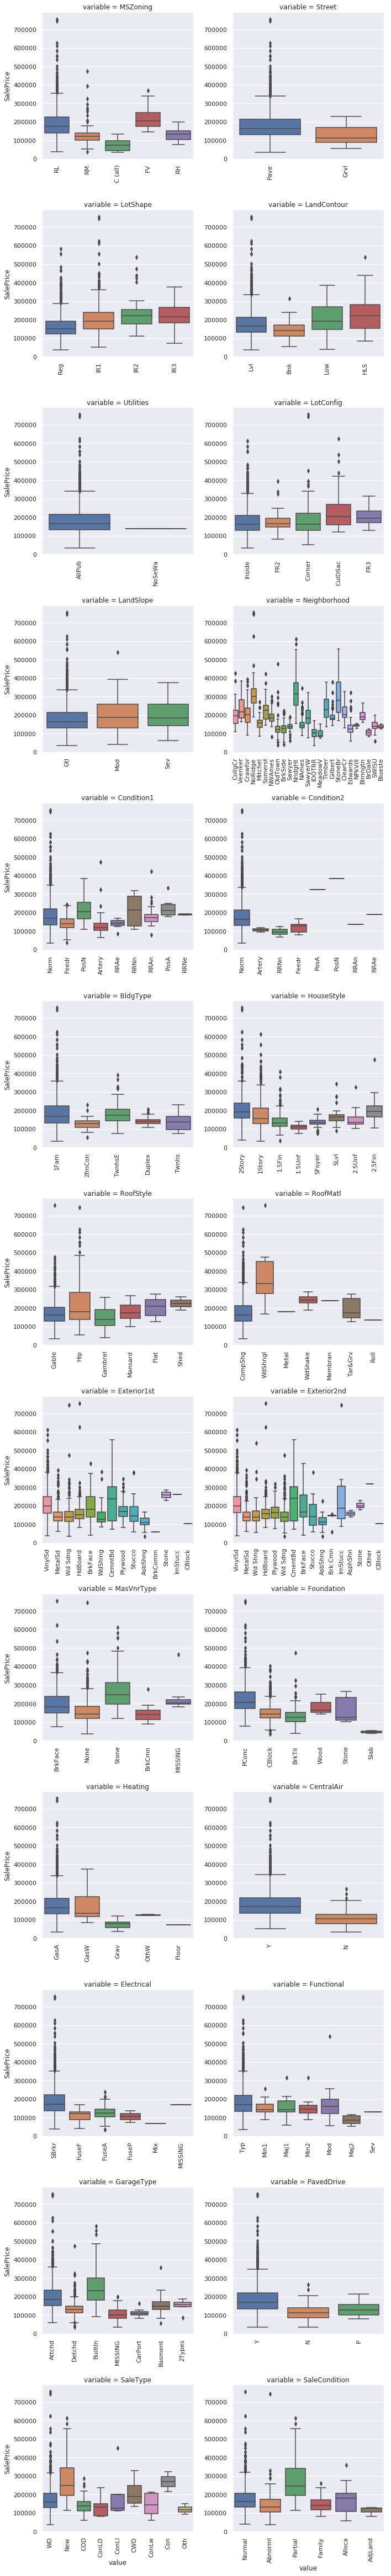

In [23]:
for c in qualitative:
    trainDF[c] = trainDF[c].astype('category')
    if trainDF[c].isnull().any():
        trainDF[c] = trainDF[c].cat.add_categories(['MISSING'])
        trainDF[c] = trainDF[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
f = pd.melt(trainDF, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(boxplot, "value", "SalePrice")

$\text{We now encode our qualitatives variables according to the ANOVA spmean ranking:}$

In [24]:
qual_encoded = []
for feature in qualitative:
    trainDF = trainDF.copy()
    ordering = pd.DataFrame()
    ordering['val'] = trainDF[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = trainDF[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    for cat, o in ordering.items():
        all_data.loc[all_data[feature] == cat, feature+'_E'] = o
    qual_encoded.append(feature + '_E')
    
print('Columns encoded :', qual_encoded)

Columns encoded : ['MSZoning_E', 'Street_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'Foundation_E', 'Heating_E', 'CentralAir_E', 'Electrical_E', 'Functional_E', 'GarageType_E', 'PavedDrive_E', 'SaleType_E', 'SaleCondition_E']


---

# $\textbf{5. Modeling}$

---

In [25]:
features = quantitative + qual_encoded

In [26]:
train = all_data.copy()

def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    all_data[feature] = np.log1p(all_data[feature].values)

def quadratic(feature):
    all_data[feature+'2'] = all_data[feature]**2
    
log_cols = ['GrLivArea','1stFlrSF','2ndFlrSF','TotalBsmtSF','LotArea','KitchenAbvGr','GarageArea']
for col in log_cols:
    log_transform(col)
    
quadra_cols = ['OverallQual','YearBuilt','YearRemodAdd','TotalBsmtSF','2ndFlrSF','Neighborhood_E','RoofMatl_E','GrLivArea']
for col in quadra_cols:
    quadratic(col)

qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']


all_data['HasBasement'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasGarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['Has2ndFloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasMasVnr'] = all_data['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasWoodDeck'] = all_data['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasPorch'] = all_data['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['IsNew'] = all_data['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']


features = quantitative + qual_encoded + boolean + qdr + log_cols

X = all_data[features].fillna(0.).values
x_train = X[:ntrain]
x_test = X[ntrain:]
#y_train #we saved it before

In [27]:
# Next we want to sample our training data to test for performance of robustness ans accuracy, before applying to the test data
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=1)

$\text{We applied transforms to the existing features and now we finally can use our models.}$

---

$\textbf{Lasso Regression :}$

In [28]:
warnings.filterwarnings('ignore')
lasso = LassoLarsCV(cv = 10)
lasso.fit(X_train, np.log(Y_train))
lassoPred = np.exp(lasso.predict(X_test))

error(Y_test, lassoPred)

0.11579085088097066

$\textbf{Ridge Regression :}$

In [29]:
ridge = Ridge()
ridge.fit(X_train, np.log(Y_train))
ridgePred = np.exp(ridge.predict(X_test))

error(Y_test, ridgePred)

0.11719740760856984

$\textbf{Bayesian Ridge Regression :}$

In [30]:
br = BayesianRidge()# parameters to find
br.fit(X_train, np.log(Y_train))

brPred = np.exp(br.predict(X_test))

error(Y_test, brPred)

0.11563562222106005

$\textbf{Naive Bayes :}$

In [31]:
gnb = GaussianNB()

le = LabelEncoder()
encodedLabels = le.fit_transform(np.log(y_train))#encode the labels

gnb.fit(x_train, encodedLabels)
encodedPred = gnb.predict(x_train)
nbPred = np.exp(le.inverse_transform(encodedPred.reshape(-1, 1)))
    
error(y_train, nbPred)

0.15247860870204863

$\textbf{Multi Layer Perceptron}$

In [32]:
mlp = MLPRegressor()# parameters to find
mlp.fit(X_train, Y_train)

mlpPred = mlp.predict(X_test)

error(Y_test, mlpPred)

0.36784070592109097

## $\textbf{Parameter Optimisation}$

$\text{First prepare the test set}$

In [33]:
models = [LassoLarsCV(),Ridge(),BayesianRidge()]

hyperparameters = {}
#BR_param_grid = {'n_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005], 
#                 'lambda_2': [0.00000001], 'copy_X': [True]}

In [34]:
warnings.filterwarnings('ignore')

In [35]:
RidgeHyperparam = {'alpha': [True,False], 'fit_intercept': stats.randint(2, 1000),
    'max_iter' : stats.uniform(0.0, 1.0), 'tol' : stats.randint(1,20), 'solver' :  ['auto', 'svd',
    'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

model = Ridge()

clf = RandomizedSearchCV(model,
                    RidgeHyperparam ,scoring = 'neg_mean_squared_error' , cv = 10, n_iter=20)

clf.fit(X_train,Y_train)
print("Best parameters set found:",clf.best_params_)
print("Randomized Grid scores:")
#for params, mean_score, scores in clf.grid_scores_:
#         print("\t%0.4f (+/-%0.04f) for %s" % (mean_score, scores.std() * 2, params))

print("Optimized Score:",(-clf.score(X_test,Y_test))**0.5)


Best parameters set found: {'alpha': True, 'fit_intercept': 212, 'max_iter': 0.48744204971944405, 'solver': 'cholesky', 'tol': 15}
Randomized Grid scores:
Optimized Score: 20988.187577388882


In [36]:
dict = {'alpha': True, 'fit_intercept': 91, 'max_iter': 0.14632112948471576, 'solver': 'svd', 'tol': 3}
dict.values()

dict_values([True, 91, 0.14632112948471576, 'svd', 3])

In [37]:
model = Ridge(alpha= True, fit_intercept= 91, max_iter= 0.14632112948471576, solver= 'svd', tol= 3)

model.fit(X_train, np.log(Y_train))

prediction = model.predict(X_test)

error(Y_test, np.exp(prediction))

0.11719740760862919

In [38]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor()]

KR_param_grid = {'alpha': [0.1], 'coef0': [100], 'degree': [1], 'gamma': [None], 'kernel': ['polynomial']}
EN_param_grid = {'alpha': [0.001], 'copy_X': [True], 'l1_ratio': [0.6], 'fit_intercept': [True], 'normalize': [False], 
                         'precompute': [False], 'max_iter': [300], 'tol': [0.001], 'selection': ['random'], 'random_state': [None]}
LASS_param_grid = {'alpha': [0.0005], 'copy_X': [True], 'fit_intercept': [True], 'normalize': [False], 'precompute': [False], 
                    'max_iter': [300], 'tol': [0.01], 'selection': ['random'], 'random_state': [None]}
GB_param_grid = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [300], 'max_depth': [3], 
                                        'min_samples_split': [0.0025], 'min_samples_leaf': [5]}
BR_param_grid = {'n_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005], 
                 'lambda_2': [0.00000001], 'copy_X': [True]}
LL_param_grid = {'criterion': ['aic'], 'normalize': [True], 'max_iter': [100], 'copy_X': [True], 'precompute': ['auto'], 'eps': [0.000001]}
RFR_param_grid = {'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [None], 'min_samples_split': [5], 'min_samples_leaf': [2]}

params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid]

after_model_compare = pd.DataFrame(columns = features)

row_index = 0
for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)

    #set name and parameters
    model_name = alg.__class__.__name__
    after_model_compare.loc[row_index, 'Name'] = model_name
    
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    after_model_compare.loc[row_index, 'Parameters'] = str(gs_alg.best_params_)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    after_training_results = np.sqrt(-gs_alg.best_score_)
    after_test_results = np.sqrt(((Y_test-gs_alg.predict(X_test))**2).mean())
    
    after_model_compare.loc[row_index, 'Train Accuracy Mean'] = (after_training_results)*100
    after_model_compare.loc[row_index, 'Test Accuracy'] = (after_test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
after_model_compare['Train Accuracy Mean'] = after_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
after_model_compare['Test Accuracy'] = after_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
after_model_compare[['Name','Test Accuracy']].sort_values(by = 'Test Accuracy')

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...
6 LassoLarsIC trained...
7 RandomForestRegressor trained...


,Name,Test Accuracy
3,GradientBoostingRegressor,1806113.212
1,ElasticNet,2041697.847
2,Lasso,2062319.378
4,BayesianRidge,2082204.842
0,KernelRidge,2093879.066
6,RandomForestRegressor,2114077.556
5,LassoLarsIC,2173333.610


In [39]:
hyperparameters = {
    'alpha': stats.uniform(0.0, 1.0),#pos float
    'fit_intercept': stats.randint(1,399),#bool {True, False}
    'normalize' : [True, False],#bool
    'max_iter': stats.uniform(0.0, 1.0),#int
    'tol': stats.uniform(0.0,1.0),#float, precision of the sol
    'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}#{‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’}

parameter_grid = list(ParameterSampler(hyperparameters, n_iter=40))

ridgePerfDF = pd.DataFrame(columns=['alpha', 'fit_intercept', 'normalize',
                                   'max_iter','tol','solver'])
for parameter_combination in parameter_grid:
    ridge = Ridge(alpha = parameter_combination['alpha'],
                                    fit_intercept = parameter_combination['fit_intercept'],
                                    normalize = parameter_combination['normalize'],
                                    copy_X = True,
                                    max_iter = parameter_combination['max_iter'],
                                    tol = parameter_combination['tol'],
                                    solver = parameter_combination['solver'],
                                    random_state = 123)
    
    ridge.fit(X_train, np.log(Y_train))
    ridgePred = ridge.predict(X_test)
    
    parameter_combination['error'] = error(Y_test, np.exp(ridgePred))
    parameter_combination['score'] = ridge.score(X_test, np.log(Y_test))
    
    ridgePerfDF = ridgePerfDF.append(parameter_combination, ignore_index=True)
ridgePerfDF.sort_values(['error','score'],ascending = True,inplace = True)
print('best parameters:\n', ridgePerfDF.loc[0][:-2])
bestParams = ridgePerfDF.loc[0][:-2]
ridgePerfDF.head(10)

best parameters:
 alpha            0.937731
fit_intercept         361
normalize            True
max_iter         0.499623
tol              0.451758
solver                svd
Name: 0, dtype: object


,alpha,fit_intercept,normalize,max_iter,tol,solver,error,score
33,0.005636,236,True,0.510928,0.873895,cholesky,0.115897,0.903021
22,0.132273,281,True,0.669664,0.394543,auto,0.116239,0.902448
26,0.160922,356,True,0.012550,0.208882,svd,0.116388,0.902197
24,0.199326,64,True,0.348001,0.046082,cholesky,0.116596,0.901847
29,0.218258,332,True,0.235790,0.022537,auto,0.116701,0.901670
11,0.245959,95,True,0.824540,0.862544,svd,0.116858,0.901404
19,0.266595,9,True,0.595535,0.830413,auto,0.116978,0.901202
34,0.072155,240,False,0.091384,0.534218,auto,0.117132,0.900943
39,0.141119,354,False,0.393018,0.095771,auto,0.117150,0.900912
5,0.230454,388,False,0.996868,0.151105,auto,0.117163,0.900890


## $\text{Predict the prices and write the submission}$
We use the model that performs best

In [40]:
bestParams

alpha            0.937731
fit_intercept         361
normalize            True
max_iter         0.499623
tol              0.451758
solver                svd
Name: 0, dtype: object

In [41]:
model = Ridge(alpha= 0.978333, fit_intercept= 58,normalize = False, max_iter= 0.239519, solver= 'cholesky', tol= 0.0561859)

model.fit(X_train, np.log(Y_train))
prediction = model.predict(X_test)

print('Model chosen :',model.__class__.__name__,'\nerror on test set :')
error(Y_test, np.exp(prediction))

Model chosen : Ridge 
error on test set :


0.11719716076523522

In [42]:
finalDF = pd.DataFrame()
final_prediction = model.predict(x_test)

finalDF['SalePrice'] = np.exp(final_prediction)
finalDF['SalePrice'] = finalDF['SalePrice'].astype(np.int)
finalDF.index = testDF['Id']
finalDF.to_csv('submission.csv')

# $\text{Conclusion}$

$\textit{Kaggle rank : 1931/4025}$

$\text{- One thing i noted alongside the different submissions, is the importance of outliers, one cannot emphasize it enough:}$

$\hspace{6pt}\text{Ingoring those outliers, the }\textit{error}\text{ was about }\textit{0.1340}\text{ on the test set and the }\textit{Kaggle rank : 1931/4025}\\\hspace{6pt}\text{Once dealt with, the }\textit{error}\text{ decreased down to }\textit{0.1171}\text{ on the test set and the }\textit{Kaggle rank : }$

$\\\text{- This challenge allowed me to devellop some basic data science skills and methods.}$

$\hspace{6pt}\text{Furthermore the notebook format forced me to have a clear process, commenting emphasized that even more.}\\\hspace{6pt}\text{This resulted in a somewhat decent result, knowing most submission are made through copying existing notebooks that reached }\\\hspace{6pt}\text{really good preformance. Even though i looked at some existing kernel i refrained myself from coppying it overeagerly and prefered}\\\hspace{6pt}\text{a look at the method employed.}$